## Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates
import GraphHelpers as GH

In [2]:
WaterDelta = pd.read_pickle('.\DataFrames\ProfileWaterDelta.pkl')

In [3]:
GPs = GH.SetGraphicsPatterns(WaterDelta.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = WaterDelta.index.min()
End = WaterDelta.index.max()

Irrigation
['Dry', 'Irrigated']
Cultivar
['Karaka', 'Moonlight', 'RussetB']
Treatments
MultiIndex(levels=[['Dry', 'Irrigated'], ['Karaka', 'Moonlight', 'RussetB']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
                    Lin     Col   Alp Mar     MFC
Dry       Karaka      -  orange  0.15   o  orange
          Moonlight   -   green  0.15   o   green
          RussetB     -  purple  0.15   o  purple
Irrigated Karaka     --  orange  0.45   ^   white
          Moonlight  --   green  0.45   ^   white
          RussetB    --  purple  0.45   ^   white


## investigate how much upward flux we are getting at night

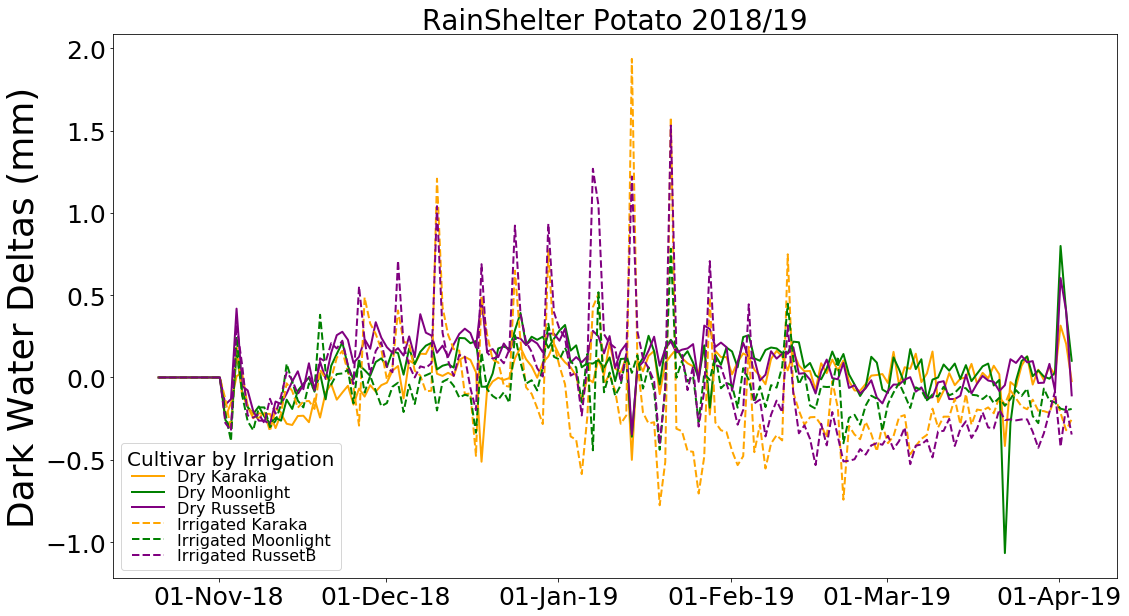

In [6]:
DarkWaterDeltas = WaterDelta.iloc[WaterDelta.index.indexer_between_time(datetime.time(23),datetime.time(4))]
DarkWaterDeltas = DarkWaterDeltas.resample('24H', base=5).sum()#Base of 5 means sampling from 6am to 6am
MeanDarkWaterDeltas = DarkWaterDeltas.groupby(level=['Irrigation','Cultivar'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanDarkWaterDeltas,ax,GPs,2)
plt.ylabel('Dark Water Deltas (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Potato 2018/19', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

## No Clear evidence of upward flux for this experiment

## Work out Irrigation timings and amounts.

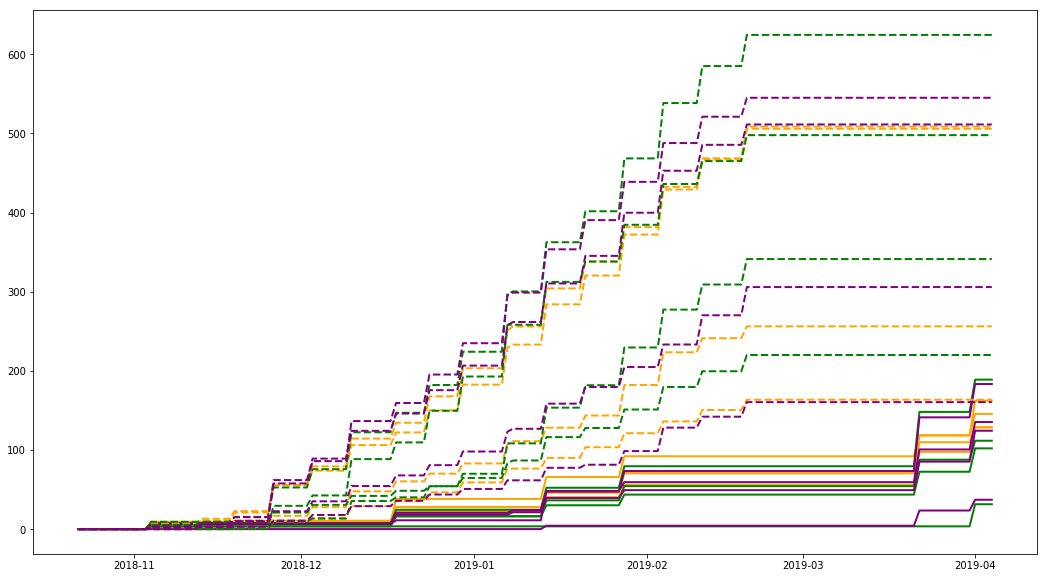

In [7]:
Irrigation = WaterDelta.where(WaterDelta > 3)
Irrigation = Irrigation.resample('D').sum()
Irrigation.fillna(0, inplace = True)
AccumIrrig = Irrigation.cumsum()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(AccumIrrig,ax,GPs,2)

In [8]:
DSIyesterday = 0

DaysSinceIrrigation = pd.DataFrame(index = Irrigation.index, columns = Irrigation.columns)
for col in range(DaysSinceIrrigation.columns.size):
    for x in range(Irrigation.index.size):
        if x == 0:
            DaysSinceIrrigation.iloc[x,col] = float(0)
        else: 
            if Irrigation.iloc[x,col] == 0:
                DaysSinceIrrigation.iloc[x,col] = float(DaysSinceIrrigation.iloc[x-1,col]+1)
            else:
                DaysSinceIrrigation.iloc[x,col] = float(0)

In [9]:
IrrDates = DaysSinceIrrigation.Dryland.loc[:,'0'].mean(axis=1) == 0.0
IrrDatesD0 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Dryland.loc[:,'50'].mean(axis=1) == 0.0
IrrDatesD50 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Dryland.loc[:,'300'].mean(axis=1) == 0.0
IrrDatesD250 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Irrigated.loc[:,'0'].mean(axis=1) == 0.0
IrrDatesI0 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Irrigated.loc[:,'50'].mean(axis=1) == 0.0
IrrDatesI50 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Irrigated.loc[:,'300'].mean(axis=1) == 0.0
IrrDatesI250 = IrrDates.loc[IrrDates].index.tolist()


AttributeError: 'DataFrame' object has no attribute 'Dryland'

In [10]:
list(set(IrrDatesD0+IrrDatesD250+IrrDatesD50+IrrDatesI0+IrrDatesI250+IrrDatesI50))

NameError: name 'IrrDatesD0' is not defined

# Calculate hourly water use values

In [11]:
#Bring in night time PET data
NightTimePETAtmospheric = pd.read_pickle('.\DataFrames/NightTimePET.pkl')
NightTimePETAtmospheric.index = NightTimePETAtmospheric.index.normalize()
NightTimePETAtmospheric = NightTimePETAtmospheric.loc['2014-11-08':] #Drop of the first day because it only has a part nights numbers and no day associated wit it
NightTimePETAtmospheric.plot(figsize=(18,10))

FileNotFoundError: [Errno 2] No such file or directory: '.\\DataFrames/NightTimePET.pkl'

## Calculate profile water content deltas for each 1 hour measurement period

(array([736999., 737029., 737060., 737091., 737119., 737150.]),
 <a list of 6 Text xticklabel objects>)

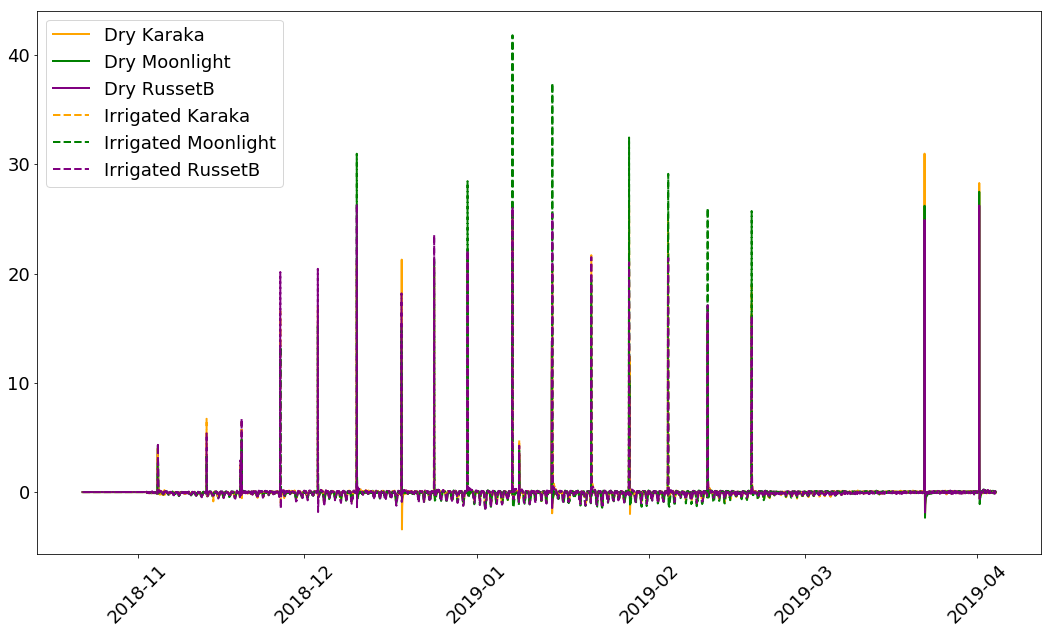

In [14]:
WaterDeltaHourly = WaterDelta.resample('h').sum()
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).std()/np.sqrt(4)
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterDeltaHourly.loc[:,:],ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)


In [15]:
UpwardFlux = DarkWaterDeltas.copy()
UpwardFlux.index = UpwardFlux.index.normalize()
for plot in  UpwardFlux:
    AdjustedFlux = UpwardFlux.loc[:,plot].values
    AdjustedFlux = np.add(AdjustedFlux,NightTimePETAtmospheric.reindex(UpwardFlux.index).values) # Add in the amount of evaporation that would have been replaced
    #AdjustedFlux = np.subtract(AdjustedFlux,NightTimeSoilHeatFlux_mm.loc[UpwardFlux.index,plot].fillna(0))
    UpwardFlux.loc[:,plot] = AdjustedFlux
UpwardFlux = UpwardFlux.multiply(4)  # Multiply by 4 assuming upflux during the day were the same as at night
UpwardFlux.fillna(0, inplace = True)
MeanUpwardFlux = UpwardFlux.groupby(level=['Irrigation','Cultivar'],axis=1).mean()

NameError: name 'NightTimePETAtmospheric' is not defined

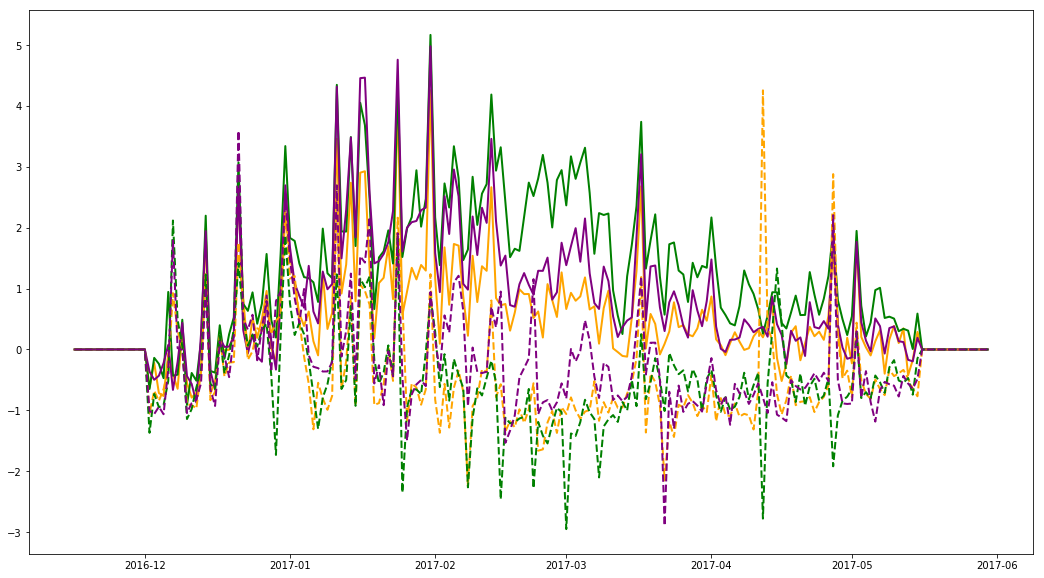

In [19]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanUpwardFlux,ax,GPs,2)

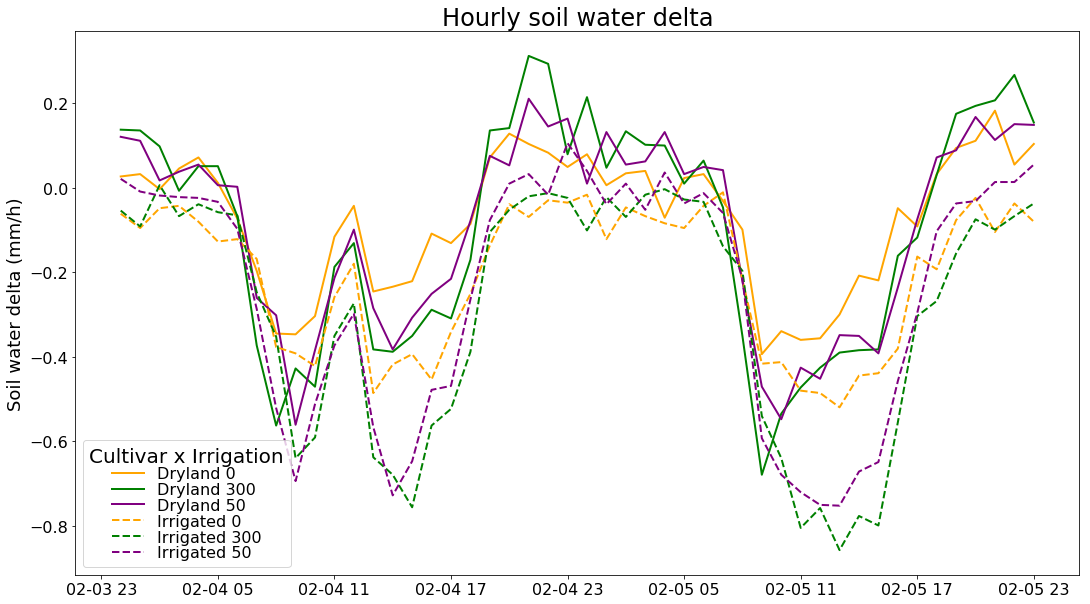

In [22]:
WaterDeltaHourly = WaterDelta.resample('h').sum()
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation','Nitrogen'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation','Nitrogen'],axis=1).std()/np.sqrt(4)
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterDeltaHourly.loc['2017-02-4':'2017-02-5'],ax,GPs,2)
GH.AddLegend(3,18,"Cultivar x Irrigation")
GH.SetAxProps(title='Hourly soil water delta',titsize=24,
              ylab='Soil water delta (mm/h)',labsize = 18,
              ticsize = 16)

(array([736299., 736330., 736361., 736389., 736420., 736450., 736481.]),
 <a list of 7 Text xticklabel objects>)

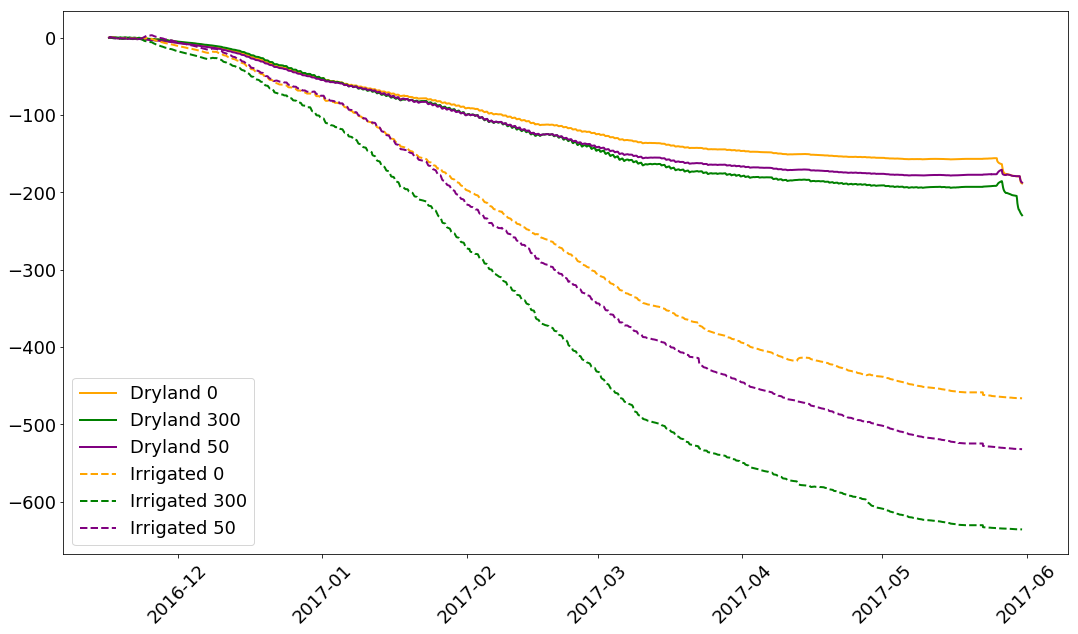

In [17]:
WaterUseHourly = WaterDeltaHourly
WaterUseHourly = WaterUseHourly.where(WaterUseHourly<1)
WaterUseHourly.fillna(method='ffill', inplace = True)
MeanWaterUseHourly = WaterUseHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterUseHourly.cumsum(),ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)

In [23]:
WaterUseHourly.to_pickle('.\DataFrames\HourlyWUmm.pkl')

## Calculate Daily Water Use

In [ ]:
#Set up daily water use sums
WaterUseDaily = WaterUseHourly.resample('D').sum()
WaterUseDaily.index.name = 'Date'

#wipe the data on the days when irrigation occured 
WaterUseDaily.loc[IrrDatesD0,('Dryland','0')] = np.nan
WaterUseDaily.loc[IrrDatesD50,('Dryland','50')] = np.nan
WaterUseDaily.loc[IrrDatesD250,('Dryland','250')] = np.nan
WaterUseDaily.loc[IrrDatesI0,('Irrigated','0')] = np.nan
WaterUseDaily.loc[IrrDatesI50,('Irrigated','50')] = np.nan
WaterUseDaily.loc[IrrDatesI250,('Irrigated','250')] = np.nan

In [ ]:
#calculate treatment means
WaterUseDailyMeans = WaterUseDaily.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
#Make water use positive
WaterUseDailyMeans = WaterUseDailyMeans.multiply(-1)

Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(WaterUseDailyMeans,ax,GPs,2)
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()
plt.plot(DayTimePET,'-r')
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)



In [ ]:
Graph = plt.figure(figsize=(8,8))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedXY(DayTimePET,WaterUseDailyMeans.reindex(DayTimePET.index.normalize()),ax,GPs,10)
plt.plot([0,10],[0,10],'-k')